In [124]:
import numpy as np
np.random.seed(42)
def gen_data(mu, delta, n, d: int = 2):
    noise = np.random.normal(loc = 0, scale = 1, size=(n, d))
    mu = np.full((n, d), mu, dtype=np.float64)

    if delta == 0.0:
        return mu + noise, np.zeros(n)
    
    # 10% of the data are abnormal
    abnormal_idx = np.random.choice(n, int(n/10), replace=False)

    mu[abnormal_idx, :] += delta

    X = mu + noise 
    Y = np.zeros(n)
    Y[abnormal_idx] = 1
    return X, Y

In [125]:
import torch
import torch.nn as nn
from typing import List
torch.manual_seed(42)
class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Domain critic network."""
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

from typing import Optional
import numpy as np
from tqdm.notebook import trange
from torch.utils.data import DataLoader

class WDGRL():
    def __init__(self, input_dim: int=2, generator_hidden_dims: List[int]=[32, 16, 8, 4, 2], critic_hidden_dims: List[int]=[32, 16, 8, 4, 2],
                 gamma: float = 0.1, _lr_generator: float = 1e-2, _lr_critic: float = 1e-2, 
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu', random_seed: Optional[int] = 0):
        if random_seed is not None:
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)
        self.gamma = gamma
        self.device = device
        self.generator = Generator(input_dim, generator_hidden_dims).to(self.device)
        self.critic = Critic(generator_hidden_dims[-1], critic_hidden_dims).to(self.device)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=_lr_generator)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=_lr_critic)
    
    def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
        """Compute gradient penalty."""
        if source_data.size(0) > target_data.size(0):
            ms = source_data.size(0)
            mt = target_data.size(0)
            gradient_penalty = 0
            for _ in range(0, ms, mt):
                source_chunk = source_data[_:_+mt]
                target_chunk = target_data
                alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
                interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
                # Domain critic outputs
                dc_output = self.critic(interpolates)
                
                # Compute gradients
                gradients = torch.autograd.grad(
                    outputs=dc_output,
                    inputs=interpolates,
                    grad_outputs=torch.ones_like(dc_output).to(self.device),
                    create_graph=True,
                    retain_graph=True,
                    only_inputs=True,
                )
                gradients = gradients[0]
                gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            if ms % mt != 0:
                source_chunk = source_data[ms-mt:]
                perm = torch.randperm(mt)
                idx = perm[:ms % mt]
                target_chunk = target_data[idx]
                alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
                interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
                # Domain critic outputs
                dc_output = self.critic(interpolates)
                
                # Compute gradients
                gradients = torch.autograd.grad(
                    outputs=dc_output,
                    inputs=interpolates,
                    grad_outputs=torch.ones_like(dc_output).to(self.device),
                    create_graph=True,
                    retain_graph=True,
                    only_inputs=True,
                )
                gradients = gradients[0]
                gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            return gradient_penalty / ((ms // mt) + (ms % mt != 0)) 
        
        # For balanced batch
        alpha = torch.rand(source_data.size(0), 1).to(self.device)
        interpolates = (alpha * source_data + ((1 - alpha) * target_data)).requires_grad_(True)
        
        # Domain critic outputs
        dc_output = self.critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=dc_output,
            inputs=interpolates,
            grad_outputs=torch.ones_like(dc_output).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        self.generator.train()
        self.critic.train()
        losses = []
        source_critic_scores = []
        target_critic_scores = []
        for epoch in trange(num_epochs, desc='Epoch'):
            loss = 0
            for (source_data, _), (target_data, _) in zip(source_loader, target_loader):
                source_data, target_data = source_data.to(self.device), target_data.to(self.device)

                # Train domain critic
                for _ in range(dc_iter):
                    self.critic_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        source_features = self.generator(source_data)
                        target_features = self.generator(target_data)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.critic(source_features)
                    dc_target = self.critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self.gamma * gradient_penalty
                    dc_loss.backward()
                    self.critic_optimizer.step()

                # Train feature extractor
                self.generator_optimizer.zero_grad()
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
                dc_source = self.critic(source_features)
                dc_target = self.critic(target_features)
                wasserstein_distance = dc_source.mean() - dc_target.mean()
                wasserstein_distance.backward()
                self.generator_optimizer.step()
                
                with torch.no_grad():
                    loss += wasserstein_distance.item()
                    
            source_critic_scores.append(self.criticize(source_loader.dataset.tensors[0].to(self.device)))
            target_critic_scores.append(self.criticize(target_loader.dataset.tensors[0].to(self.device)))
            losses.append(loss/len(source_loader))
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {wasserstein_distance.item()}')
        return losses, source_critic_scores, target_critic_scores
    
    @torch.no_grad()
    def extract_feature(self, x: torch.Tensor) -> torch.Tensor:
        self.generator.eval()
        return self.generator(x)
    
    @torch.no_grad()
    def criticize(self, x: torch.Tensor) -> float:
        self.generator.eval()
        self.critic.eval()
        return self.critic(self.generator(x)).mean().item()

In [126]:
# Create a new instance of the WDGRL model (same architecture as before)
model = WDGRL(input_dim=1, generator_hidden_dims=[10], critic_hidden_dims=[10])

# Load the saved checkpoint
checkpoint = torch.load("wdgrl.pth", map_location=model.device, weights_only=True)

# Restore the model weights
model.generator.load_state_dict(checkpoint['generator_state_dict'])
model.critic.load_state_dict(checkpoint['critic_state_dict'])

print("Model loaded successfully!")

Model loaded successfully!


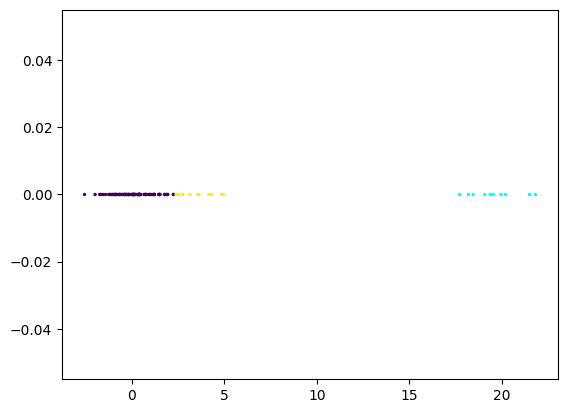

In [127]:
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 100, 10, 1
mu_s, mu_t = 0, 20
delta_s, delta_t = 4, 0
xs, ys = gen_data(mu_s, delta_s, ns, d)
xt, yt = gen_data(mu_t, delta_t, nt, d)

plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [128]:
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

xs_hat = model.extract_feature(xs)
xt_hat = model.extract_feature(xt)
print(xt_hat)

tensor([[1.1802, 0.5477, 0.1720, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1794, 0.5475, 0.1707, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1803, 0.5478, 0.1722, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1797, 0.5476, 0.1712, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1798, 0.5476, 0.1714, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1785, 0.5473, 0.1693, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1792, 0.5475, 0.1705, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1796, 0.5476, 0.1710, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1784, 0.5472, 0.1691, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.1806, 0.5478, 0.1726, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])


In [129]:
x_hat = torch.cat([xs_hat, xt_hat], dim=0)
O = []
alpha = 0.5
for i in range(x_hat.shape[1]):
    x_hat_i = x_hat[:, i]
    median = x_hat_i.median().item()
    mad = torch.abs(x_hat_i - median).median().item()
    lower = median - alpha * mad
    upper = median + alpha * mad
    for j in range(nt):
        value = xt_hat[j, i].item()
        if (value < lower or value > upper) and j not in O:
            O.append(j)
O

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [130]:
yt_hat = torch.zeros_like(yt)
yt_hat[O] = 1

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      10.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0

Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


c:\Users\loi27\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loi27\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loi27\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

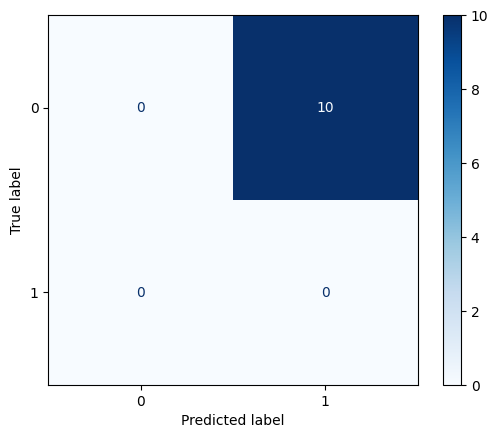

In [131]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(yt, yt_hat)
precision = precision_score(yt, yt_hat)
recall = recall_score(yt, yt_hat)
f1 = f1_score(yt, yt_hat)

# Print classification report
print(classification_report(yt, yt_hat))

# Print the scores
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(yt, yt_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)  
plt.show()

In [132]:
from mpmath import mp
mp.dps = 500

Oc = list(torch.where(yt == 0)[0])
j = np.random.choice(O, 1, replace=False)[0]
etj = np.zeros((nt, 1))
etj[j][0] = 1
etOc = np.zeros((nt, 1))
etOc[Oc] = 1
etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))
X = np.vstack((xs.numpy(), xt.numpy()))

etajTX = etaj.T.dot(X)
mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
sigma = np.identity(ns+nt)
etajTmu = etaj.T.dot(mu)
etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)
cdf = mp.ncdf((etajTX[0][0] - etajTmu[0][0]) / np.sqrt(etajTsigmaetaj[0][0]))
p_value = float(2 * min(cdf, 1 - cdf))
p_value

0.048789458888769975

# Naive $p$-value

In [136]:
def run_naive():
    ns, nt, d = 100, 10, 1
    mu_s, mu_t = 0, 20
    delta_s, delta_t = 4, 0
    xs, ys = gen_data(mu_s, delta_s, ns, d)
    xt, yt = gen_data(mu_s, delta_t, nt, d)

    xs = torch.FloatTensor(xs)
    ys = torch.LongTensor(ys)
    xt = torch.FloatTensor(xt)
    yt = torch.LongTensor(yt)
    
    xs_hat = model.extract_feature(xs)
    xt_hat = model.extract_feature(xt)
    x_hat = torch.cat([xs_hat, xt_hat], dim=0)
    
    O = []
    alpha = 0.5
    for i in range(x_hat.shape[1]):
        x_hat_i = x_hat[:, i]
        median = x_hat_i.median().item()
        mad = torch.abs(x_hat_i - median).median().item()
        lower = median - alpha * mad
        upper = median + alpha * mad
        for j in range(nt):
            value = xt_hat[j, i].item()
            if (value < lower or value > upper) and j not in O:
                O.append(j)
    
    if len(O) == 0:
        return None
    
    Oc = list(torch.where(yt == 0)[0])
    j = np.random.choice(O, 1, replace=False)[0]
    etj = np.zeros((nt, 1))
    etj[j][0] = 1
    etOc = np.zeros((nt, 1))
    etOc[Oc] = 1
    etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))
    X = np.vstack((xs.numpy(), xt.numpy()))

    etajTX = etaj.T.dot(X)
    mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
    sigma = np.identity(ns+nt)
    etajTmu = etaj.T.dot(mu)
    etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)
    cdf = mp.ncdf((etajTX[0][0] - etajTmu[0][0]) / np.sqrt(etajTsigmaetaj[0][0]))
    p_value = float(2 * min(cdf, 1 - cdf))
    return p_value

FPR: 0.067


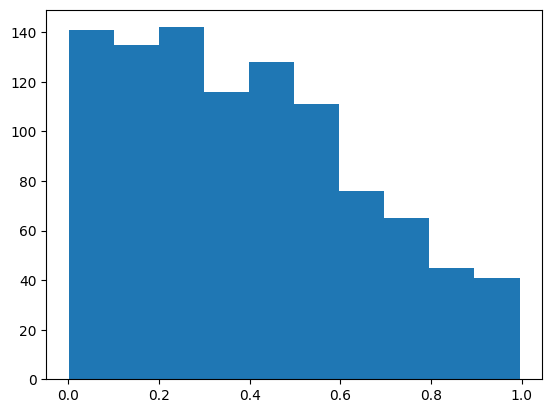

In [137]:
max_iteration = 1000
alpha = 0.05
list_p_value = []
count = 0

for i in range(max_iteration):
    p_value = run_naive()
    if p_value is None:
        continue
    list_p_value.append(p_value)
    if p_value <= alpha:
        count += 1
print(f'FPR: {count / max_iteration}')
plt.hist(list_p_value)
plt.show()

In [135]:
b = sigma.dot(etaj).dot(np.linalg.inv(etajTsigmaetaj))
a = (np.identity(ns+nt) - b.dot(etaj.T)).dot(X)